In [1]:
# Defining the required access keys for uploading the experiment with the server
%env AWS_ACCESS_KEY_ID=XSHDLTACETFLQURZSAUJ
%env AWS_SECRET_ACCESS_KEY=ISvyN9Aay40ZIaMuQcngOCJdzkSqR85ON1ng9PNZ
%env MLFLOW_S3_ENDPOINT_URL=http://s3.padre-lab.eu
%env MLFLOW_TRACKING_URI=http://mlflow.padre-lab.eu
%env MONGO_DB = pypads
%env MONGO_USER=pypads
%env MONGO_URL=mongodb://www.padre-lab.eu:2222
%env MONGO_PW=8CN7OqknwhYr3RO

env: AWS_ACCESS_KEY_ID=XSHDLTACETFLQURZSAUJ
env: AWS_SECRET_ACCESS_KEY=ISvyN9Aay40ZIaMuQcngOCJdzkSqR85ON1ng9PNZ
env: MLFLOW_S3_ENDPOINT_URL=http://s3.padre-lab.eu
env: MLFLOW_TRACKING_URI=http://mlflow.padre-lab.eu
env: MONGO_DB=pypads
env: MONGO_USER=pypads
env: MONGO_URL=mongodb://www.padre-lab.eu:2222
env: MONGO_PW=8CN7OqknwhYr3RO


## Initialize the tracking system of PyPads

In [2]:
from pypads.app.base import PyPads

tracker = PyPads(uri="http://mlflow.padre-lab.eu")
tracker.activate_tracking()
tracker.start_track(experiment_name="PyTorch Example")

2020-10-12 09:17:23.502 | INFO     | pypads.app.base:activate_tracking:555 - Activating tracking by extending importlib...
2020-10-12 09:17:24.634 | WARNING  | pypads.app.misc.managed_git:preserve_changes:84 - There are uncommitted changes in your git!
2020-10-12 09:17:24.976 | WARNING  | pypads.app.misc.managed_git:create_tracking_branch:134 - Stashing, branching out, committing, reverting back and unstashing...
2020-10-12 09:17:25.267 | INFO     | pypads.app.misc.managed_git:preserve_changes:91 - Created branch PyPads/a3fd2498dd2a4815a07a4f402cc5a266
2020-10-12 09:17:25.506 | WARNING  | pypads.app.misc.managed_git:_handle_error:19 - Couldn't initialized git repository because of exception: Preserving commit failed due to INVALID_PARAMETER_VALUE: Tag value 'diff --git a/.idea/.gitignore b/.idea/.gitignore
new file mode 100644
index 0000000..73f69e0
--- /dev/null
+++ b/.idea/.gitignore
@@ -0,0 +1,8 @@
+# Default ignored files
+/shelf/
+/workspace.xml
+# Datasource local storage ignored

In [3]:
# Set the random seed to 1
tracker.actuators.set_random_seed(seed=1)

/home/christofer/PycharmProjects/pypads-notebooks/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/christofer/PycharmProjects/pypads-notebooks/venv/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:125: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


## Import the dataset from Scikit-learn

In [4]:
from sklearn import datasets

# load the iris datasets
dataset = datasets.load_iris()
X = dataset.data
y = dataset.target


/home/christofer/PycharmProjects/pypads-notebooks/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Do the test train split

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

# PyTorch Dataloader takes the data as one block which includes the features and labels
# Append labels to the features
train = np.append(X_train, y_train.reshape((y_train.shape[0],1)), axis=1)
train.shape

/home/christofer/PycharmProjects/pypads-notebooks/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(90, 5)

## Create Torch class for accepting neural network shapes

In [6]:
import torch
from torch import nn
from typing import Any
from collections import OrderedDict

class Model(nn.Module):
    def _forward_unimplemented(self, *input: Any) -> None:
        pass
    
    def __init__(self, feature_shape, leaky_value=0.05, shape=[30, 50, 1]):
        
        # Model can have as many layers as the user wishes
        super(Model, self).__init__()
        layers = [feature_shape] + shape
        layer_list = OrderedDict()
        for idx in range(1, len(layers)):
            layer_list[str(idx)] = nn.Linear(layers[idx-1], layers[idx])
            layer_list['Relu' + str(idx)] = nn.LeakyReLU(leaky_value, inplace=True)

        layer_list['Sigmoid'] = nn.Sigmoid()
        self.model = nn.Sequential(layer_list)

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity
    

In [7]:
# Define the various training parameters
num_features = X.shape[1]
num_labels = 3
num_epochs = 75
test_every = 10
h_lr = 0.005
h_b1 = 0.5
h_b2 = 0.999
batch_size = 10
neural_network_shape = [10, 10, 3]

## Track the parameters using PyPads

In [8]:
# Normal parameters can be stored as is in MLFlow
tracker.api.log_param(key='lr', value=h_lr, description='Learning rate')

'2a190660-cd0f-414b-ba38-df448ca4e348.parameter'

In [9]:
# MLFlow takes in strings as parameters. So convert the value to string
tracker.api.log_param(key='networks_shape', value=str(neural_network_shape), description='Shape of the fully connected network')

'246c13f0-1d14-4d86-94c3-d83693b8402f.parameter'

In [10]:
# Create the model
model = Model(feature_shape=num_features, shape=neural_network_shape)

In [11]:
# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=h_lr, betas=(h_b1, h_b2))

In [12]:
# Create the loss function
loss_ = torch.nn.BCELoss()

In [13]:
# Function to train for one epoch
from torch.utils.data import DataLoader

def train_one_epoch(model, loader: DataLoader, tensor, optimizer, loss_, scheduler=None):
    total_loss = 0
    n_iter = 0
    for batch_idx, (batch_train_features, batch_train_labels) in enumerate(loader):

        features_batch = tensor(batch_train_features.type(torch.FloatTensor))
        labels_batch = tensor(batch_train_labels)
        
        optimizer.zero_grad()

        # Compute loss
        forward = model.forward(features_batch)
        _loss = loss_(forward, labels_batch)
        
        # Do backpropagation and update weights
        _loss.backward()
        optimizer.step()
        
        # If there is a learning rate scheduler do the step.
        if scheduler is not None:
            scheduler.step()
        
        # Compute the total loss
        total_loss += _loss
        n_iter += 1
    
    # Return average loss
    return total_loss / n_iter

In [14]:
# Function to split the batch into features and labels
def sample_collate(batch):
    # Hard coded values for classification and iris dataset
    one_hot = True
    num_labels = 3
    
    # Stack each tensor variable
    X = torch.stack([torch.tensor(x[:-1]) for x in batch])
    
    # Convert to one hot encoding, if needed
    if one_hot is False:
        Y = [y[-1] for y in batch]
    else:
        Y = torch.zeros(len(batch), num_labels)
        for idx in range(len(batch)):
            Y[idx][int(batch[idx][-1])] = 1
    
    # Return features and labels
    return X, Y

In [15]:
# Create the data loader for training. Sample collate function is defined in the previous cell
loader = DataLoader(train, batch_size=10, shuffle=True, collate_fn=sample_collate)

In [16]:
# Create a progress bar for the training
import ipywidgets as widgets
from IPython.display import display

t = widgets.FloatProgress(value=0,
                          min=0,
                          max=1.0,
                          step=0.1,
                          description='Loading:',
                          bar_style='info',
                          orientation='horizontal')

/home/christofer/PycharmProjects/pypads-notebooks/venv/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(FloatProgress).__init__(step=0.1).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


In [17]:
# Set the labels as integers from 0 to the number of labels
labels = [i for i in range(num_labels)]


# Use CUDA if it is available
cuda = True if torch.cuda.is_available() else False
tensor = torch.cuda.FloatStorage if cuda else torch.FloatTensor


# Do a test of the initial accuracy of the classifier
results = model.forward(tensor(X_test))
predicted = torch.max(results.data, 1)
y_pred = predicted.indices.tolist()

# Print the initial accuracy
print('Initial accuracy is %f ' % accuracy_score(y_true=y_test.tolist(), y_pred=y_pred))

# Display the initial progress bar
display(t)


Initial accuracy is 0.633333 


FloatProgress(value=0.0, bar_style='info', description='Loading:', max=1.0)

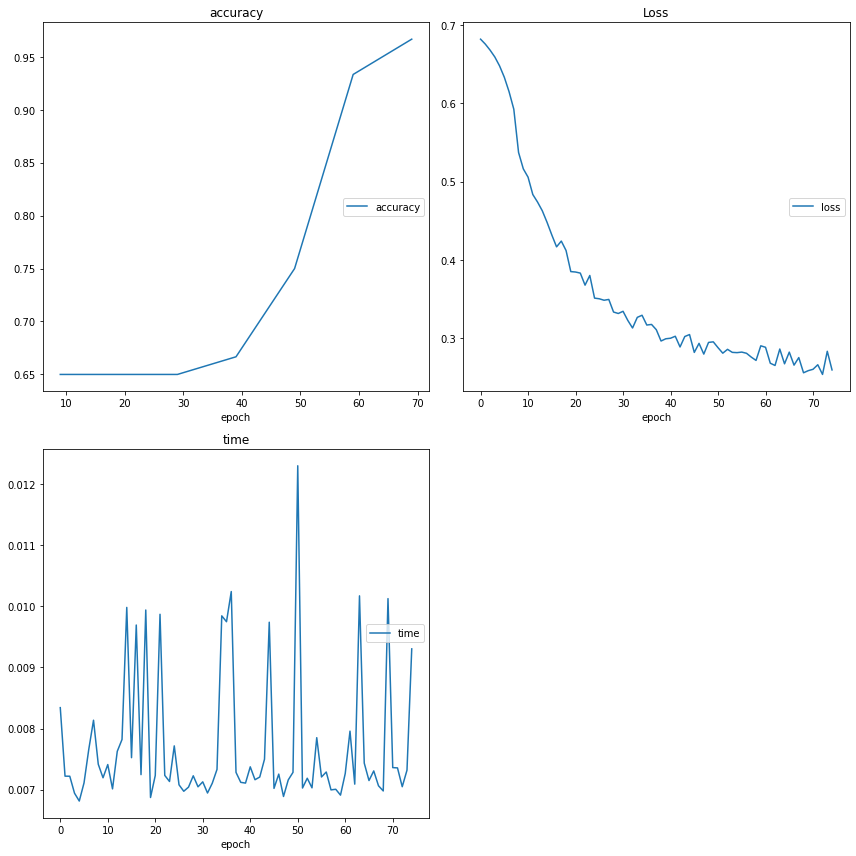

accuracy
	accuracy         	 (min:    0.650, max:    0.967, cur:    0.967)
Loss
	loss             	 (min:    0.253, max:    0.682, cur:    0.259)
time
	time             	 (min:    0.007, max:    0.012, cur:    0.009)


In [18]:
from livelossplot import PlotLosses
from time import time
import matplotlib.pyplot as plt

epochs_trained = 0

# Plot losses help with visualizing the loss at run time as a live plot
liveloss = PlotLosses()

for idx in range(num_epochs):

    t1 = time()
    n_iter = 0
    average_loss = 0.0

    average_loss = train_one_epoch(model=model, loader=loader, optimizer=optimizer, loss_=loss_, tensor=tensor)
    
    t2 = time()
    epochs_trained += 1
    
    # Update the progress bar
    # Progress bar will be updated in the previous cell because the plots are draw over it
    t.value = epochs_trained/num_epochs
    
    # Create dictionary for live plot
    logs = {}
    
    # Test every certain number of epochs
    if epochs_trained % test_every == 0:
        
        # Do a forward pass
        results = model.forward(tensor(X_test))
        
        # Get the predicted classes. Predicted classes have the max values
        predicted = torch.max(results.data, 1)
        
        # Get the indices corresponding to the max values and convert them to a list. 
        y_pred = predicted.indices.tolist()
        
        # Compute the accuracy_score and log it to PyPads.
        # Note the step parameter specifies the step in training where this accuracy was obtained.
        accuracy = accuracy_score(y_true=y_test.tolist(), y_pred=y_pred)
        tracker.api.log_metric(key='accuracy', value=accuracy, description='Accuracy of the model', step=epochs_trained)
        
        # Add accuracy to the dictionary
        logs['accuracy'] = accuracy
        
    # Update the dictionary with average_loss and execution time and plot it
    logs['loss'] = average_loss
    logs['time'] = t2 - t1
    liveloss.update(logs)
    liveloss.send()

In [19]:
# Compute the final test scores
results = model.forward(tensor(X_test))
predicted = torch.max(results.data, 1)
y_pred = predicted.indices.tolist()

# Print the classification report
print(classification_report(y_true=y_test.tolist(), y_pred=y_pred, labels=labels))

2020-10-12 09:17:54.201 | WARNING  | pypads.injections.analysis.parameters:__post__:109 - No parameters are defined on the mapping file for <class 'sklearn.preprocessing._label.LabelEncoder'>. Trying to log parameters without schema definition programmatically.
2020-10-12 09:17:54.271 | WARNING  | pypads.injections.analysis.parameters:__post__:109 - No parameters are defined on the mapping file for <class 'sklearn.preprocessing._label.LabelEncoder'>. Trying to log parameters without schema definition programmatically.


/home/christofer/PycharmProjects/pypads-notebooks/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2020-10-12 09:17:54.351 | WARNING  | pypads.injections.analysis.parameters:__post__:109 - No parameters are defined on the mapping file for <class 'sklearn.preprocessing._label.LabelEncoder'>. Trying to log parameters without schema definition programmatically.
2020-10-12 09:17:54.431 | WARNING  | pypads.injections.analysis.parameters:__post__:109 - No parameters are defined on the mapping file for <class 'sklearn.preprocessing._label.LabelEncoder'>. Trying to log parameters without schema definition programmatically.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.86      0.92        21
           2       0.87      1.00      0.93        20

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



## Adding a metric to be tracked by PyPads

In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=y_test.tolist(), y_pred=y_pred)
# Track a metric using PyPads with the name as key, a description of the metric and 
# Setting step to 0 to indicate that this is the final value
tracker.api.log_metric(key='accuracy', value=accuracy, description='Accuracy of the model')

'b8175faa-859b-43bb-9dfd-b5334b074d64.metric'

## Tracked Information

In [ ]:
tracker.api.active_run().info

In [ ]:
metrics = tracker.api.get_metrics(run_id=tracker.api.active_run().info.run_id, history=True)
print(metrics)

### Get all the artefacts

In [ ]:
artifacts = tracker.results.list_run_infos('PyTorch Example')


### Metrics Information

In [ ]:
metrics = tracker.api.get_metrics(run_id=tracker.api.active_run().info.run_id, history=True)
print(metrics)

### Tracked Parameter Information

In [ ]:
parameters = tracker.api.get_parameters(run_id=tracker.api.active_run().info.run_id)
print(parameters)

### End tracking of experiment

In [ ]:
tracker.api.end_run()

In [ ]:
x_values
